# Polynomial Solver using SGD and TinyGrad


### Library Installs and Imports

In [399]:
!python3 --version

Python 3.8.16


Installing tinygrad and tdqm

In [400]:
!pip install git+https://github.com/geohot/tinygrad.git
!pip install tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/geohot/tinygrad.git to /tmp/pip-req-build-t24ttawq
  Running command git clone -q https://github.com/geohot/tinygrad.git /tmp/pip-req-build-t24ttawq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing necessary modules

In [401]:
from tinygrad.tensor import Tensor
import tinygrad.nn.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tqdm import tqdm
from operator import itemgetter

### Data preprocessing


Importing data_train.csv and data_test.csv from Github. The values given in data_train.csv will serve as training data while the values given in our data_test.csv will serve as testing data.

In [402]:
data_train_raw = "https://raw.githubusercontent.com/juliannecc/ML-Activities/main/02_Polynomial_Solver/data_train.csv"
data_test_raw = "https://raw.githubusercontent.com/juliannecc/ML-Activities/main/02_Polynomial_Solver/data_test.csv"

data_train = pd.read_csv(data_train_raw)
data_test = pd.read_csv(data_test_raw)

Getting validation data from training data. This validation data is used to tune our prediction. 

In [403]:
X_train, X_validate, Y_train, Y_validate = train_test_split([[i] for i in data_train["x"]], [[i] for i in data_train["y"]], test_size=0.15, random_state=42)
X_test, Y_test = [[i] for i in data_test["x"]], [[i] for i in data_test["y"]]

Visualizing data_train, data_validate and data_test.

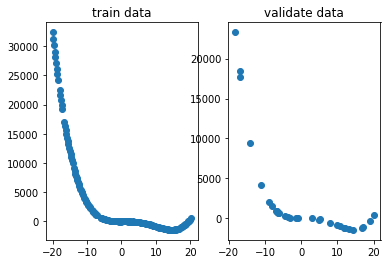

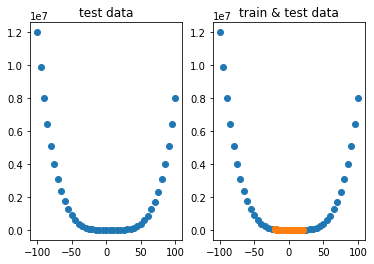

In [404]:
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.scatter(X_train, Y_train)
ax1.set_title('train data')

ax2.scatter(X_validate, Y_validate)
ax2.set_title('validate data')

plt.savefig("train-validate.png")
plt.show()

fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.scatter(X_test, Y_test)
ax1.set_title('test data')

ax2.scatter(X_test, Y_test)
ax2.scatter(X_train, Y_train)
ax2.set_title('train & test data')

plt.savefig("test-train_and_test.png")
plt.show()

### Model Building, Training and Validation

Creating a model class responsible for forward propagation and random polynomial initialization (first prediction).



In [405]:
class Model:
  def __init__(self, pol_deg):
    """ Generates a random polynomial """
    self.poly = [Tensor([np.array([np.random.uniform(-1,1)])], requires_grad=True) for i in range(pol_deg+1)]

  def load_polynomial(self, polynomial):
    """ Loads the given polynomial """
    self.poly = [Tensor([np.array(coeff)], requires_grad = True) for coeff in polynomial]

  def reshaped_tensor(self):
    """ Reshapes the tensor polynomial """
    reshaped_tensor = self.poly[0]
    [reshaped_tensor := reshaped_tensor.cat(self.poly[i]) for i in range(1,len(self.poly))]
    return reshaped_tensor
  
  def forward_pass(self,x):
    """ Forward Propagation """
    return x.matmul(self.reshaped_tensor()).sum(axis=1)  

  def get_polynomial(self):
    """ Returns the polynomial """
    return [i.data[0] for i in self.poly]

Creating a function to calculate MSE loss on tensors:

$$
MSE = \frac{1}{n} \sum_i (y_{pred} - y_{GT})^2
$$

In [406]:
def calc_mse(y_pred,y_gt):
  return (y_gt-y_pred).square().mean()

Creating a [loader](https://www.leaky.ai/dataloader) class for setting batches and getting polynomial features. These features will help better our prediction as it contain varying degrees. 

Take Note: 
$$
h_\theta (x) = \sum^n_{k=0} \theta_kx^k \\ 
\begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix} = \begin{bmatrix} 1 & x_1 & x_1^2 & \cdots & x_1^n \\ 1 & x_2 & x_2^2 & \cdots & x_2^n \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & x_m & x^2_m & \cdots & x^n_m & \end{bmatrix} \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} + ϵ 
$$

(equation from [[1]](https://www.youtube.com/watch?v=5NMAjtRHphc&t=191s))

In [407]:
class Loader:
  def __init__(self, X, Y, batch_size=64, shuffle = True, polyfeatures=True, degree=4):
    self.X = X
    self.Y = Y
    self.batch_size = batch_size
    self.polyfeatures = polyfeatures
    self.degree = degree
    self.shuffle = shuffle

  def __iter__(self): 
    if self.shuffle: self.shuffle_data()
    # https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
    for i in range(0, len(self.X),self.batch_size):
      X_batch = self.X[i:min(i + self.batch_size, len(self.X))]
      Y_batch = self.Y[i:min(i + self.batch_size, len(self.X))]
      if self.polyfeatures: X_batch = self.get_feats(X_batch)
      yield X_batch, Y_batch

  def get_feats(self, x):
    # https://rickwierenga.com/blog/ml-fundamentals/polynomial-regression.html
    b = np.hstack((np.ones((len(x), 1)),x))
    feats = np.hstack([((b[:,1] ** i).reshape((len(x),1))) for i in range(self.degree+1)])
    # feats[:, 1:] = (feats[:, 1:] - np.mean(feats[:, 1:], axis=0)) / np.std(feats[:, 1:], axis=0)

    feats_tensor = Tensor(feats, requires_grad = False)
    return feats_tensor

  # https://stackoverflow.com/questions/32019398/python-sorting-y-value-array-according-to-ascending-x-array
  def unshuffle_data(self):
    L = sorted(zip(self.X,self.Y), key=itemgetter(0))
    self.X, self.Y = zip(*L)

  def shuffle_data(self):
    x_shuffled = []
    y_shuffled = []

    i = np.random.permutation(len(self.X))
    for idx in range(len(self.X)):
      x_shuffled.insert(i[idx],self.X[idx])
      y_shuffled.insert(i[idx],self.Y[idx])
    self.X = x_shuffled
    self.Y = y_shuffled

Setting hyperparameters

In [408]:
epochs = 200
batch_size = 64
learning_rate = [0.0003, 0.00003, 0.000003, 0.00000003, 0.0000000003]

Training the model with regularization. 

$$
|x|=\sqrt{\sum^n_{k=1}|x_k|^2}
$$

See [[2]](https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec06-slides.pdf) and [[3]](https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec06-slides.pdf)

Model training and validation 

In [409]:
best_models = []
losses = []

# iterating through degrees 1-4 to find the model with the least loss
for degree in range (4,0,-1):
  model = Model(degree) # initialize first prediction
  optimizer = optim.SGD(model.poly, lr=learning_rate[degree])

  # load train and validate data
  train = Loader(X_train, Y_train, batch_size, True, True, degree)
  validate = Loader(X_validate, Y_validate, batch_size, False, True, degree)

  # Reguralization Parameter
  alpha = 0.5

  best = []
  bestloss = None

  for epoch in tqdm(range(epochs)):

    for x, y in train:
      out = model.forward_pass(x).reshape(-1,1)
      # Penalty term to prevent overfitting  https://www.youtube.com/watch?v=KpBmD3bLfX4
      l2_pen = alpha * model.reshaped_tensor()[1:].mul(model.reshaped_tensor()[1:]).sqrt().sum()
      loss = calc_mse(y, out) + l2_pen
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    validate_loss = 0
    for x, y in validate:
      out = model.forward_pass(x).reshape(-1,1)
      vloss = calc_mse(y, out).data[0]
      validate_loss += vloss*len(out.data[0])
    
    validate_loss /= len(train.X)

    # gets the model with the least loss 
    if bestloss is None:
      bestloss = validate_loss
    else:
      if bestloss > validate_loss:
        bestloss = validate_loss
        best = [c[0] for c in model.get_polynomial()]

  # appends the model to best_models regardless of degree
  best_models.append([c[0] for c in model.get_polynomial()])
  losses.append(bestloss)

100%|██████████| 200/200 [00:09<00:00, 21.92it/s]


Getting the best model based on the computed losses. 

In [410]:
# getting the model with the least loss considering the degree
best_coeffs = best_models[losses.index(min(losses))]
print(f"Best Coefficients: {best_coeffs}")

Best Coefficients: [0.16137871, 0.24552433, -0.33745804, -1.941491, 0.10375239]


### Model Testing

Visualizing model's prediction against given training and testing data.

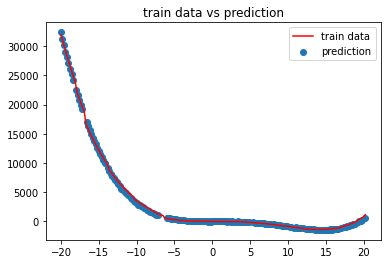

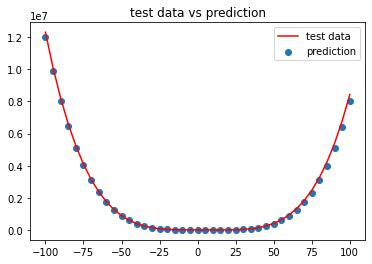

In [411]:
best_model = Model(len(best_coeffs)-1)
best_model.load_polynomial(np.array(best_coeffs).reshape(-1,1))

train = Loader(X_train, Y_train, 64, False, True, len(best_coeffs)-1)
train.unshuffle_data()

X_train_pred = np.linspace(min(X_train), max(X_train), len(X_train))
Y_train_pred = best_model.forward_pass(train.get_feats(train.X)).reshape(-1, 1)
plt.scatter(X_train,Y_train)
plt.plot(X_train_pred, Y_train_pred.data, color='red')
plt.title("train data vs prediction")
plt.legend(['train data', 'prediction'])
plt.show()

test = Loader(X_test,Y_test,64, False, True, len(best_coeffs)-1)
X_test_pred = np.linspace(min(X_test), max(X_test), len(X_test)).reshape(-1, 1)
Y_test_pred = best_model.forward_pass(test.get_feats(X_test)).reshape(-1, 1)

plt.scatter(X_test, Y_test)
plt.plot(X_test_pred, Y_test_pred.data, color='red')
plt.title("test data vs prediction")
plt.legend(['test data', 'prediction'])
plt.show()

Checking model accuracy on testing and training data using $R^2$ metric. 

$R^2$ tells how well predictor variables can explain the variation from actual data. This value ranges from 0 to 1 and the higher the value the better. [[4]](https://www.statology.org/rmse-vs-r-squared/)



In [412]:
# https://www.datatechnotes.com/2019/10/accuracy-check-in-python-mae-mse-rmse-r.html

# Training data Y_train_pred
train = Loader(X_train, Y_train, 64, False, True, len(best_coeffs)-1)
train.unshuffle_data()

Y_train_pred = best_model.forward_pass(train.get_feats(X_train))
train_mse = metrics.mean_squared_error(Y_train, Y_train_pred.data)
train_r2 = metrics.r2_score(Y_train, Y_train_pred.data)

print(f"train r2: {train_r2}")
# Testing data
test_mse = metrics.mean_squared_error(Y_test, Y_test_pred.data)
test_r2 = metrics.r2_score(Y_test, Y_test_pred.data)

print(f"test r2: {test_r2}")

train r2: 0.9993702087955111
test r2: 0.9980709191226806


### Resources 

[1] A. Bazzi, “Polynomial Regression with Broid | Dr. Ahmad Bazzi,” *YouTube*. Nov. 02, 2020. Accessed: Dec. 14, 2022. [YouTube Video]. Available: https://www.youtube.com/watch?v=5NMAjtRHphc&t=191s

[2] University of Toronto. (2013). CSC 411 Lecture 6: Linear Regression. [Online]. Available: https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec06-slides.pdf
‌

[3]
Marton Trencseni, “PyTorch Basics: Solving the Ax=b matrix equation with gradient descent,” Bytepawn - Marton Trencseni, Feb. 07, 2019. https://bytepawn.com/pytorch-basics-solving-the-axb-matrix-equation-with-gradient-descent.html (accessed Dec. 15, 2022).

[4]
Zach, “RMSE vs. R-Squared: Which Metric Should You Use?,” *Statology*, Jun. 22, 2021. https://www.statology.org/rmse-vs-r-squared/ (accessed Dec. 16, 2022).‌